In [1]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from tqdm import tqdm
np.random.seed(0)
torch.manual_seed(0)

/anaconda/envs/hw_094295_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [70]:
BATCH_SIZE = 16
NUM_EPOCHS = 5
LR = 0.001

base_dir = os.path.join("/home/student/hw2_094295", "data_original")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

In [71]:
def load_datasets(train_dir, val_dir):
    """Loads and transforms the datasets."""
    # Resize the samples and transform them into tensors
    data_transforms = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor()])

    # Create a pytorch dataset from a directory of images
    train_dataset = datasets.ImageFolder(train_dir, data_transforms)
    val_dataset = datasets.ImageFolder(val_dir, data_transforms)

    return train_dataset, val_dataset


train_dataset, val_dataset = load_datasets(train_dir, val_dir)

class_names = train_dataset.classes
print("The classes are: ", class_names)

The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


In [72]:
# Dataloaders initialization
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

NUM_CLASSES = len(class_names)

In [74]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=100):
    """Responsible for running the training and validation phases for the requested model."""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {'train': [], 'val': []}
    acc_dict = {'train': [], 'val': []}
    correctness_dict = {}
    real_probs_dict = {}
    labels_dict = {}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                for j in range(len(outputs)):
                    image_key = f"{i}_{j}_{phase}"
                    output = outputs[j]
                    pred = int(preds[j])
                    real = int(labels.data[j])
                    probs = torch.nn.functional.softmax(output)
                    if image_key not in correctness_dict:
                        correctness_dict[image_key] = 0.0
                        real_probs_dict[image_key] = []
                        labels_dict[image_key] = class_names[real]
                        
                    correctness_dict[image_key] += int(pred == real)
                    real_probs_dict[image_key].append(float(probs[real]))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            acc_dict[phase].append(epoch_acc.item())
            loss_dict[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # If the current epoch provides the best validation accuracy so far, save the model's weights.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    confidence_dict = {}
    variablity_dict = {}

    for key, value in real_probs_dict.items():
        confidence_dict[key] = np.mean(value)
        variablity_dict[key] = np.std(value)

    for key, value in correctness_dict.items():
        correctness_dict[key] = value/NUM_EPOCHS
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_dict, acc_dict, correctness_dict, confidence_dict, variablity_dict, labels_dict

In [77]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model_ft, loss_dict, acc_dict, correctness_dict, confidence_dict, variablity_dict, labels_dict = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=NUM_EPOCHS)

Epoch 1/5
----------


  0%|          | 0/130 [00:00<?, ?it/s]/tmp/ipykernel_6126/3170662125.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(output)
100%|██████████| 130/130 [00:10<00:00, 11.87it/s]


train Loss: 2.5070 Acc: 0.2143


100%|██████████| 1/1 [00:00<00:00, 36.72it/s]


val Loss: 2.4985 Acc: 0.3000

Epoch 2/5
----------


100%|██████████| 130/130 [00:10<00:00, 12.12it/s]


train Loss: 1.6873 Acc: 0.4291


100%|██████████| 1/1 [00:00<00:00, 36.77it/s]


val Loss: 1.2528 Acc: 0.6000

Epoch 3/5
----------


 20%|██        | 26/130 [00:02<00:08, 12.25it/s]Bad pipe message: %s [b'K\xdb\xa2hw\x19\x96\x90\xfb\xc5S\xba\x84\xc3*\x99K\xa3 l\x9e\xcd\x12\xc7G/\xce)gM\xac\x9a>}\x02\x06\x1a\x16_\x9e\x89\xc3\xafR\x9ac\xc8\x83\xf45\xed\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00']
Bad pipe message: %s [b'|v\xc3\xd7d\xeb{\x9f\xe2\xff\x1d:\x82\xc1+%?^\x00\x00>\xc0\x14\xc0\n\x009\x008\x007\x006\xc0\x0f\xc0\x05\x00', b'\x13\xc0\t\x003\x002\x001\x000\xc0\x0e\xc0\x04\x00/\x00\x9a\x00\x99\x00\x98\x00\x97\x00\x96\x00\x07\xc0\x11\xc0\x07\xc0\x0c\xc0\x02\x00\x05\x00\x04\x00\xff\x02\x01\x00\x00C\x00\x00\x00\x0e']
Bad pipe message: %s [b'\xaf\x93\xa6\xaa\x8d#\xc9\x91\x17\x8bJ\rUw\x87\xaf\xdb\xb2\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005\x00\x84\xc0\x13\xc0\t\x003\

train Loss: 1.3135 Acc: 0.5776


100%|██████████| 1/1 [00:00<00:00, 35.76it/s]


val Loss: 1.3386 Acc: 0.5000

Epoch 4/5
----------


100%|██████████| 130/130 [00:10<00:00, 12.08it/s]


train Loss: 1.0763 Acc: 0.6672


100%|██████████| 1/1 [00:00<00:00, 36.98it/s]


val Loss: 0.8455 Acc: 0.8000

Epoch 5/5
----------


100%|██████████| 130/130 [00:10<00:00, 12.11it/s]


train Loss: 0.8647 Acc: 0.7402


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


val Loss: 0.7365 Acc: 0.7000

Training complete in 0m 54s
Best val Acc: 0.800000


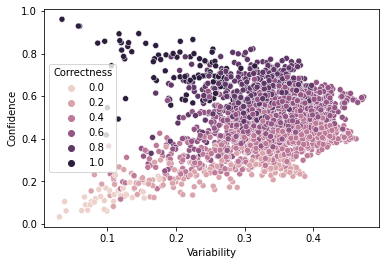

In [43]:
import seaborn as sns
import pandas as pd 
data = pd.DataFrame({'Variability': variablity_dict, 'Confidence': confidence_dict, 'Correctness': correctness_dict})
sns.scatterplot(data=data, x="Variability", y="Confidence", hue="Correctness")
plt.title("Model performance over 5 epochs")
plt.show()

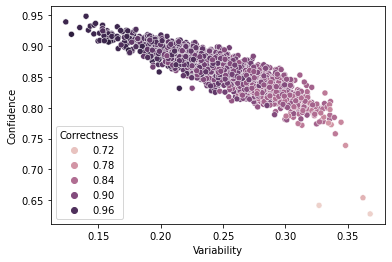

In [36]:
import seaborn as sns
import pandas as pd 
data = pd.DataFrame({'Variability': variablity_dict, 'Confidence': confidence_dict, 'Correctness': correctness_dict})
sns.scatterplot(data=data, x="Variability", y="Confidence", hue="Correctness")
plt.show()

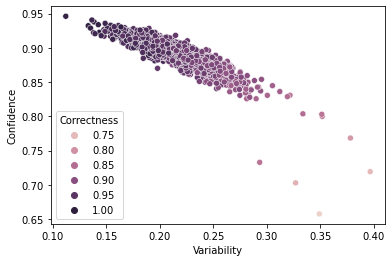

In [29]:
import seaborn as sns
import pandas as pd 
data = pd.DataFrame({'Variability': variablity_dict, 'Confidence': confidence_dict, 'Correctness': correctness_dict})
sns.scatterplot(data=data, x="Variability", y="Confidence", hue="Correctness")
plt.show()

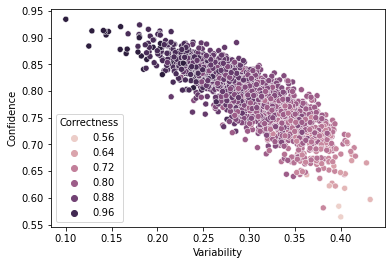

In [17]:
import seaborn as sns
sns.scatterplot(data=data, x="Variability", y="Confidence", hue="Correctness")
plt.show()